# Typical Time History of the Grid Demand

Please see the ``README`` for instructions about accessing the data (UIUC Grid Data is currently not cleared for publication). 

In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../../data/'
fy15 = read_csv(path+"2015_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy15 = fy15.rename(columns={"Value (KW)":"kw", 
                            "eDNA Status as String":"status"})

fy16 = read_csv(path+"2016_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy16 = fy16.rename(columns={"Value (KW)":"kw", 
                            "eDNA Status as String":"status"})

fy17 = read_csv(path+"2017_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy17 = fy17.rename(columns={"Value (KW)":"kw", 
                            "eDNA Status as String":"status"})

fy18 = read_csv(path+"2018_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy18 = fy18.rename(columns={"Value (KW)":"kw", 
                            "eDNA Status as String":"status"})

fy19 = read_csv(path+"2019_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy19 = fy19.rename(columns={"Value (KW)":"kw", 
                            "eDNA Status as String":"status"})

## Combine Datasets

In [3]:
frames = [fy15, fy16, fy17, fy18, fy19]
time_series = pd.concat(frames)
# time_series.time = time_series.index
time_series

,kw,status
Date and Time,,
2014-07-01 00:00:00,61731.0,OK
2014-07-01 01:00:00,60009.0,OK
2014-07-01 02:00:00,58725.0,OK
2014-07-01 03:00:00,58282.0,OK
2014-07-01 04:00:00,58684.0,OK
...,...,...
2019-06-30 19:00:00,55136.0,OK
2019-06-30 20:00:00,54423.0,OK
2019-06-30 21:00:00,57478.0,OK


In [4]:
mask = time_series['status'] == 'UNRELIABLE'
time_series[mask]

,kw,status
Date and Time,,
2014-10-21 16:00:00,0.000,UNRELIABLE
2014-10-21 17:00:00,0.000,UNRELIABLE
2014-10-21 18:00:00,0.000,UNRELIABLE
2014-10-21 19:00:00,0.000,UNRELIABLE
2014-10-21 20:00:00,0.000,UNRELIABLE
...,...,...
2016-04-29 11:00:00,55176.523,UNRELIABLE
2016-05-24 12:00:00,43617.027,UNRELIABLE
2016-06-02 12:00:00,58510.026,UNRELIABLE


#### Check "unreliable" data

In [5]:
time_series_hours = time_series.copy()
time_series_hours['time'] = time_series_hours.index
time_series_hours
time_series_hours_unreliable = time_series_hours[mask]

In [6]:
time_series_hours

,kw,status,time
Date and Time,,,
2014-07-01 00:00:00,61731.0,OK,2014-07-01 00:00:00
2014-07-01 01:00:00,60009.0,OK,2014-07-01 01:00:00
2014-07-01 02:00:00,58725.0,OK,2014-07-01 02:00:00
2014-07-01 03:00:00,58282.0,OK,2014-07-01 03:00:00
2014-07-01 04:00:00,58684.0,OK,2014-07-01 04:00:00
...,...,...,...
2019-06-30 19:00:00,55136.0,OK,2019-06-30 19:00:00
2019-06-30 20:00:00,54423.0,OK,2019-06-30 20:00:00
2019-06-30 21:00:00,57478.0,OK,2019-06-30 21:00:00


/home/dotson/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


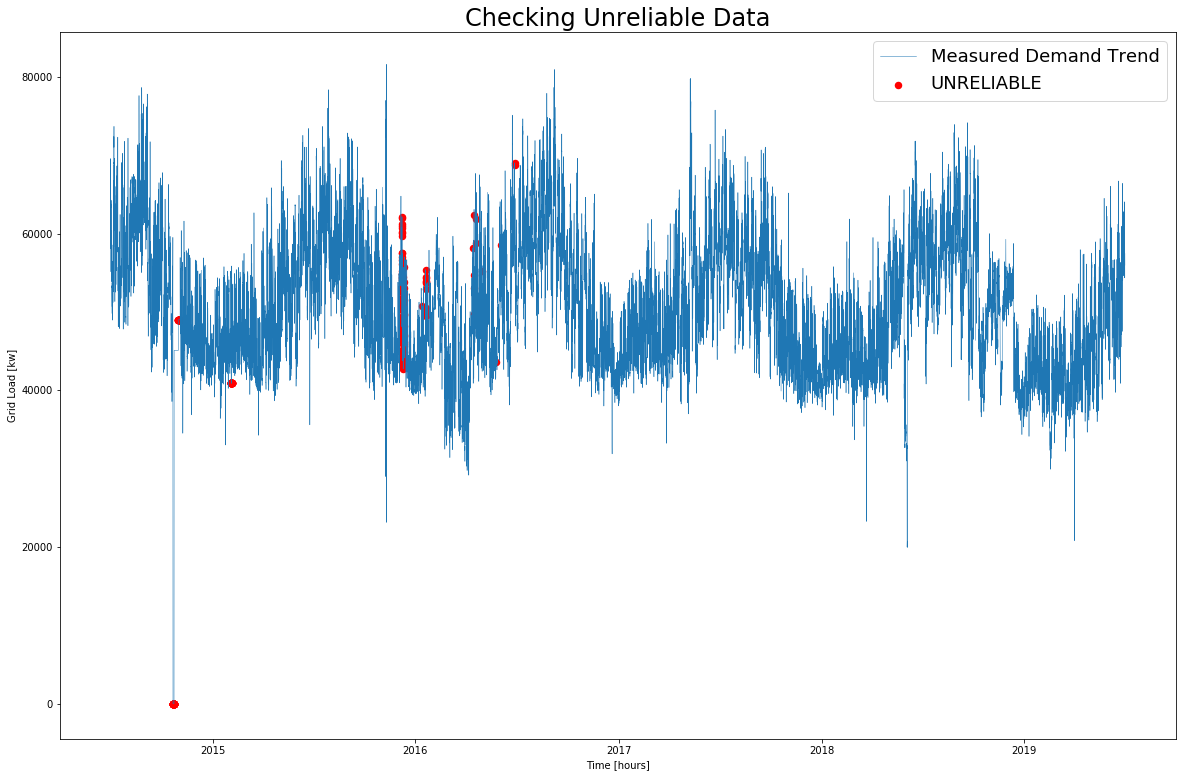

In [7]:
fig = plt.figure(figsize=(20,13), facecolor='w')
trend = plt.plot(time_series_hours['time'], time_series_hours['kw'], lw=0.5, label="Measured Demand Trend")

legend = True
for hour, power in zip(list(time_series_hours_unreliable['time'].values), 
                       list(time_series_hours_unreliable['kw'].values)):
  if legend:
    # I only want it to show up on the legend once
    plt.scatter(hour, power, color='r',marker='o', linewidths=1.5,label='UNRELIABLE')
    legend = False
  else:
    plt.scatter(hour, power, color='r',marker='o', linewidths=1.5)



plt.legend(fontsize=18)
plt.title('Checking Unreliable Data', fontsize=24)
plt.xlabel('Time [hours]')
plt.ylabel('Grid Load [kw]')
plt.show()

#### Based on the above graph, the "unreliable" data seems to be mostly false positives. 

Except for the 0 demand in 2014, which won't be included anyway because we can only use years we have complete datasets for... 

## Separate by year and pass to RAVEN

In [8]:
%%capture

grouped = time_series.groupby(time_series.index.year)

df15 = grouped.get_group(2015)
df16 = grouped.get_group(2016)[:8760] # must be same length as other years
df17 = grouped.get_group(2017)
df18 = grouped.get_group(2018)

df15.reset_index(inplace=True)
df16.reset_index(inplace=True)
df18.reset_index(inplace=True)
df17.reset_index(inplace=True)

df18['time'] = df18.index
df17['time'] = df17.index
df16['time'] = df16.index
df15['time'] = df15.index

df18 = df18[['time','kw']]
df17 = df17[['time','kw']]
df16 = df16[['time','kw']]
df15 = df15[['time','kw']]

In [9]:
df15

,time,kw
0,0,41903.0
1,1,43479.0
2,2,43572.0
3,3,43253.0
4,4,43566.0
...,...,...
8755,8755,43157.0
8756,8756,42881.0
8757,8757,42259.0
8758,8758,42260.0


In [10]:
# writes the header file for RAVEN
fname = 'annual_load201'
keys = [fname + str(i) + '.csv' for i in range(5,9,1)]
header_file = pd.DataFrame({'scaling':np.zeros(len(keys), dtype=np.int8), 'filename':keys})
header_file.to_csv(path+'annual_load_H.csv')
print(keys)

['annual_load2015.csv', 'annual_load2016.csv', 'annual_load2017.csv', 'annual_load2018.csv']


In [11]:
df15.to_csv(path+'annual_load2015.csv')
df16.to_csv(path+'annual_load2016.csv')
df17.to_csv(path+'annual_load2017.csv')
df18.to_csv(path+'annual_load2018.csv')

## RAVEN

In [13]:
!~/Research/raven/raven_framework ~/Research/2020-dotson-optimal-sizing/inputfiles/typical_demand.xml

CONDA
raven_libraries          /home/dotson/anaconda3/envs/raven_libraries
Running RAVEN in "opt" mode.
/home/dotson/Research/raven/framework/utils/utils.py:579: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp, os.path
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'colle

(    0.07 sec) PostProcessor            : DEBUG           -> InterfacedPostProcessor Post-Processor typicalHistory : start to run
/home/dotson/Research/raven/framework/PostProcessorFunctions/TypicalHistoryFromHistorySet.py:271: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  (counts, _) = np.histogram(data,bins=binEdgesIn,normed=True)
/home/dotson/Research/raven/framework/PostProcessorFunctions/TypicalHistoryFromHistorySet.py:271: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produc

(    0.22 sec) HistorySet               : DEBUG           -> Printing metadata XML: "TypicalDemand.xml"
(    0.23 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    0.23 sec) STEP IOCOMBINED          : Message         -> ***     Closing the step      ***
(    0.23 sec) STEP IOCOMBINED          : Message         -> ***        Step closed        ***
(    0.23 sec) SIMULATION               : Message         -> -- End step write of type: IOStep                              --

--------------------------------------------------
There were 1 warnings during the simulation run:
(1 time) DataObject._convertToDict can be a slow operation and should be avoided where possible!
--------------------------------------------------
(    0.23 sec) SIMULATION               : Message         -> Run complete!


In [14]:
typical_demand = pd.read_csv(path+"TypicalDemand_0.csv")

typical_demand['date'] = pd.date_range(start='1/1/2018', end='1/1/2019', freq='H')[:8760]

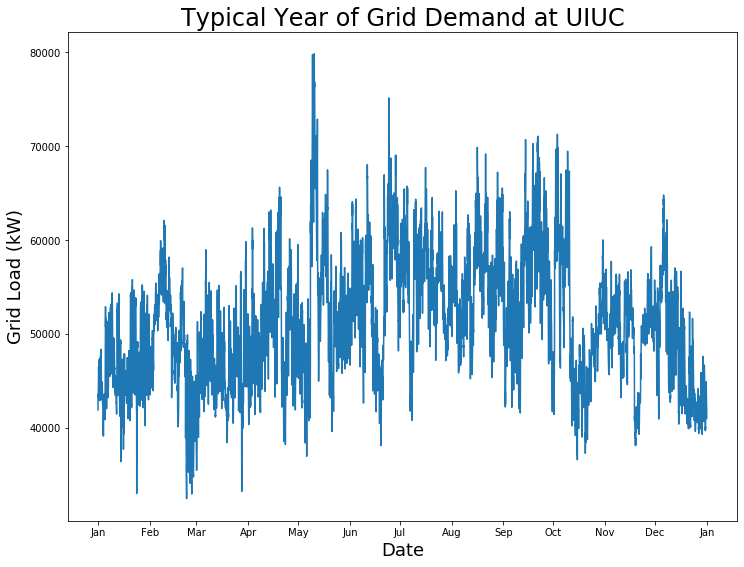

In [15]:
import matplotlib.dates as mdates


# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(typical_demand.date, typical_demand.kw)
plt.title('Typical Year of Grid Demand at UIUC', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Grid Load (kW)',fontsize=18)

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()


In [16]:
typical_demand

,time,kw,date
0,0,41903.0,2018-01-01 00:00:00
1,1,43479.0,2018-01-01 01:00:00
2,2,43572.0,2018-01-01 02:00:00
3,3,43253.0,2018-01-01 03:00:00
4,4,43566.0,2018-01-01 04:00:00
...,...,...,...
8755,8755,43157.0,2018-12-31 19:00:00
8756,8756,42881.0,2018-12-31 20:00:00
8757,8757,42259.0,2018-12-31 21:00:00
8758,8758,42260.0,2018-12-31 22:00:00


#### We need to calculate the CDF to create a custom distribution for RAVEN sampling

Text(0.5, 1.0, 'ECDF for UIUC Grid Demand')

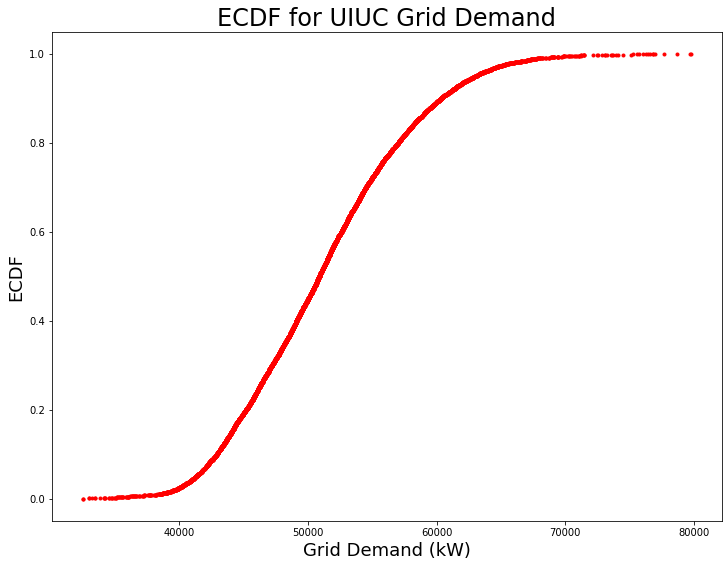

In [17]:
p = np.sort(typical_demand['kw'])
y = np.arange(1, len(p)+1)/len(p)

fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(p, y, marker='.', linestyle='none', color='r')
plt.xlabel("Grid Demand (kW)", fontsize=18)
plt.ylabel("ECDF", fontsize=18)
plt.title("ECDF for UIUC Grid Demand", fontsize=24)

In [18]:
# check average of p
print(p.mean())

51275.16808709679


#### Constructing the ARMA 

Information and examples for constructing an ARMA can be found in the ``RAVEN`` framework files under

``~/raven/tests/framework/ROM/TimeSeries/ARMA``

##### I received an error ``ValueError: x must be strictly increasing``
My ``x`` is ``p``. Attempting to resolve this now... 

We cannot simply remove non-unique values because a cdf relies on a percentage of data points. This would skew the data.

I created a function that forces monotonicity by checking if it is a repeat value. If it is, the value is increased slightly enough to call it "increasing." The statistics are unchanged. 

##### Working ARMA and Lessons Learned
It was very unclear to me what kind of sampling strategy was being used by Baker et. al. I guessed it was a Monte Carlo sampling of a distribution based on the Empirical Cumulative Distribution Function (ECDF) of the typical history. 

I was having an issue where the "synthetic histories" generated this way were constant values. This is obviously incorrect. I removed the ``<variable>`` field from my ``Sampler`` and then everything worked perfectly. Thus there is **_no need to generate a file with CDF data_**. 

In [19]:
df_cdf = pd.DataFrame({'kw':p, 'cdf':y})

In [20]:
# check for monotonicity 

print(all(i < j for i, j in zip(df_cdf['kw'], df_cdf['kw'][1:])))
print(all(i < j for i, j in zip(df_cdf['cdf'], df_cdf['cdf'][1:])))

False
True


Text(0.5, 1.0, 'ECDF for UIUC Grid Demand')

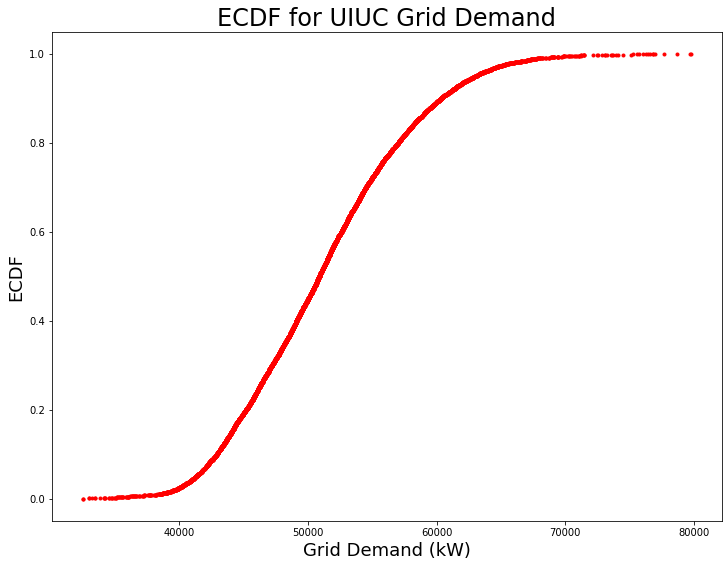

In [21]:
# import data functions
from data_funcs import make_increasing

p = make_increasing(df_cdf['kw'].values)

y = np.arange(1, len(p)+1)/len(p)

fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(p, y, marker='.', linestyle='none', color='r')
plt.xlabel("Grid Demand (kW)", fontsize=18)
plt.ylabel("ECDF", fontsize=18)
plt.title("ECDF for UIUC Grid Demand", fontsize=24)

In [22]:
p.mean()

51275.16808723789

In [23]:
df_cdf['kw'] = p

# verify the monotonicity has been enforced
print(all(i < j for i, j in zip(df_cdf['kw'], df_cdf['kw'][1:])))
print(all(i < j for i, j in zip(df_cdf['cdf'], df_cdf['cdf'][1:])))

True
True


In [24]:
# download cdf data

df_cdf.to_csv(path+"grid_cdf.csv")

In [25]:
!~/Research/raven/raven_framework ~/Research/2020-dotson-optimal-sizing/inputfiles/demand_arma.xml

CONDA
raven_libraries          /home/dotson/anaconda3/envs/raven_libraries
Running RAVEN in "opt" mode.
/home/dotson/Research/raven/framework/utils/utils.py:579: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp, os.path
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'colle

(    0.09 sec) SIMULATION               : Message         -> -- Beginning step read of type: IOStep                              --
(    0.10 sec) STEP IOCOMBINED          : Message         -> ***  Beginning initialization ***
(    0.10 sec) STEP IOCOMBINED          : DEBUG           -> jobHandler initialized
(    0.10 sec) STEP IOCOMBINED          : Message         -> ***    Initialization done    ***
(    0.10 sec) STEP IOCOMBINED          : Message         -> ***       Beginning run       ***
(    0.10 sec) HistorySet               : DEBUG           -> Reading metadata from "/home/dotson/Research/data/TypicalDemand.xml"
(    0.11 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/TypicalDemand.csv.csv"
(    0.12 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/TypicalDemand_0.csv.csv"
(    0.13 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    0.13 se

(    8.86 sec) STEP MULTIRUN            : DEBUG           -> Just collected output  1 of the input      6
(    8.86 sec) STEP MULTIRUN            : DEBUG           -> Testing if the sampler is ready to generate a new input
(    8.86 sec) MonteCarlo               : DEBUG           -> Found new point to sample: {'scaling': 1.0}
(    9.05 sec) STEP MULTIRUN            : DEBUG           -> Just collected output  1 of the input      7
(    9.05 sec) STEP MULTIRUN            : DEBUG           -> Testing if the sampler is ready to generate a new input
(    9.05 sec) MonteCarlo               : DEBUG           -> Found new point to sample: {'scaling': 1.0}
(    9.23 sec) STEP MULTIRUN            : DEBUG           -> Just collected output  1 of the input      8
(    9.23 sec) STEP MULTIRUN            : DEBUG           -> Testing if the sampler is ready to generate a new input
(    9.23 sec) MonteCarlo               : DEBUG           -> Found new point to sample: {'scaling': 1.0}
(    9.41 sec) S

In [26]:
synthetic_history = pd.read_csv(path+"demandHistories_2.csv")

Text(0.5, 1.0, 'Synthetic and Typical Demand Histories')

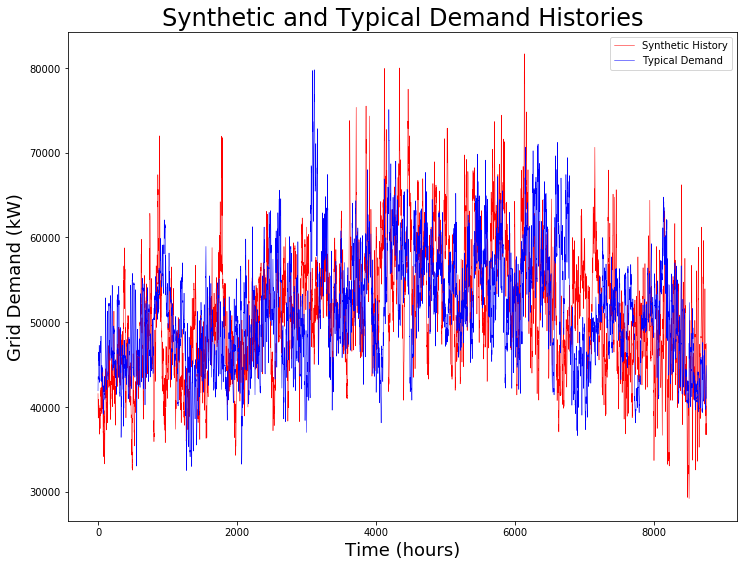

In [27]:
# plot synthetic history
fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(synthetic_history['time'], synthetic_history['kw'], 
         color='r',lw = 0.5, label='Synthetic History')
plt.plot(typical_demand['time'], typical_demand['kw'], 
         color='b', lw=0.5, label='Typical Demand')
plt.ylabel("Grid Demand (kW)", fontsize=18)
plt.xlabel("Time (hours)", fontsize=18)
plt.legend()
plt.title("Synthetic and Typical Demand Histories", fontsize=24)

In [28]:
print("Average typical demand is {}. Average synthetic demand is {}".format(typical_demand.kw.mean(), synthetic_history.kw.mean()))

Average typical demand is 51275.16808709677. Average synthetic demand is 51198.27275026197
